In [1]:
import os
import numpy as np
import tensorflow as tf
from utils.logger import Logger
import models.model_picker as mp
import params.param_picker as pp
import matplotlib.pyplot as plt

In [2]:
vals_norm = np.load("Resistance_Program_Log_Norm.npz")

In [3]:
vals = np.load("Resistance_Program_Log.npz")

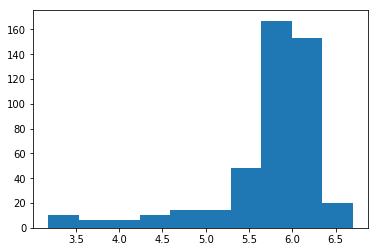

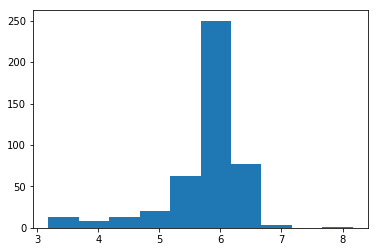

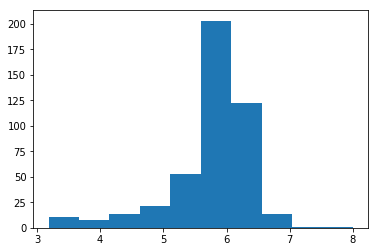

In [4]:
for i in range(3):
    res = vals['arr_'+str(i)]
    plt.hist(res.flatten())
    plt.show()

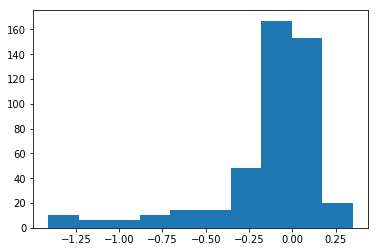

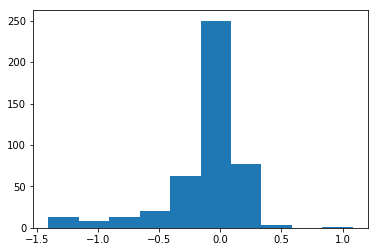

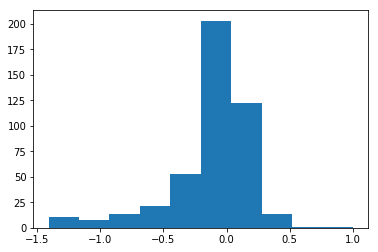

In [5]:
for i in range(3):
    res = vals_norm['arr_'+str(i)]
    plt.hist(res.flatten())
    plt.show()

In [6]:
weight_locs = ["/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b3.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b4.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b5.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b_gdn3.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b_gdn4.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/b_gdn5.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w3.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w4.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w5.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w_gdn3.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w_gdn4.npz",
"/home/dpaiton/Work/Projects/conv_gdn_autoencoder/analysis/0.0/w_gdn5.npz"]

In [7]:
weights = [np.load(file)["data"] for file in weight_locs]
res = vals_norm["arr_0"]

In [8]:
[print(weight.shape) for weight in weights]

(128,)
(128,)
(1,)
(128,)
(128,)
(1,)
(5, 5, 128, 7)
(5, 5, 128, 128)
(9, 9, 1, 128)
(128, 128)
(128, 128)
(1, 1)


[None, None, None, None, None, None, None, None, None, None, None, None]

In [9]:
model_type = "conv_gdn_decoder"
## Import params
params, schedule = pp.get_params(model_type)
## Import model
model = mp.get_model(model_type)
model.setup(params, schedule)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config, graph=model.graph) as sess:
  ## Need to provide shape if batch_size is used in graph
  sess.run(model.init_op,
    feed_dict={model.x:np.zeros([model.batch_size]+model.input_shape, dtype=np.float32)})
  feed_dict = model.get_feed_dict(res, None)
  feed_dict[model.b_init_list] = weights[0:3]
  feed_dict[model.b_igdn_init_list] = weights[3:6]
  feed_dict[model.w_init_list] = weights[6:9]
  feed_dict[model.w_igdn_init_list] = weights[9:]
  recon = sess.run(model.u_list[-1], feed_dict)


06/28/18 12:10:11 -- <params>{
  "b_thresh_min": 0.001,
  "batch_size": 1,
  "data_dir": "/home/rzarcone/Work/Datasets/",
  "data_file": "/media/tbell/datasets/verified_images.txt",
  "device": "/gpu:0",
  "eps": 1e-12,
  "gdn_mult_min": 1e-06,
  "input_channels": [
    7,
    128,
    128
  ],
  "input_shape": [
    8,
    8,
    7
  ],
  "model_name": "conv_gdn_decoder",
  "model_type": "conv_gdn_decoder",
  "out_dir": "/home/rzarcone/Work/Projects/",
  "output_channels": [
    128,
    128,
    1
  ],
  "patch_size_x": [
    5,
    5,
    9
  ],
  "patch_size_y": [
    5,
    5,
    9
  ],
  "rand_seed": 1234567890,
  "strides": [
    2,
    2,
    4
  ],
  "version": "0.0",
  "w_thresh_min": 0.001
}</params>

06/28/18 12:10:11 -- <schedule>null</schedule>
0
(5, 5, 128, 7)


ValueError: Cannot convert an unknown Dimension to a Tensor: ?